# Compare geolocation over time in archived tweets
Sanity check: are the archived tweets less likely to be geolocated over time? It seems that way based on spot checks but we need to be sure before we draw any conclusions.

In [1]:
import gzip
import pandas as pd
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import os
import json
from datetime import datetime
from multiprocessing import Pool
import re

In [2]:
old_archive = '/hg190/corpora/twitter-crawl/daily-tweet-archives/'
old_tweet_files = [os.path.join(old_archive, f) for f in os.listdir(old_archive) if '.gz' in f]
new_archive = '/hg190/corpora/twitter-crawl/new-archive/'
new_tweet_files = [os.path.join(new_archive, f) for f in os.listdir(new_archive) if '.gz' in f]
combined_tweet_files = old_tweet_files + new_tweet_files

In [4]:
print('%d total files to process'%(len(combined_tweet_files)))

1364 total files to process


That's a lot! How about we take one file per month?

In [15]:
date_matcher = re.compile('[A-Z][a-z]{2}-[0-3][0-9]-1[0-9]')
tweet_file_month_year = [date_matcher.findall(f)[0] for f in combined_tweet_files]
tweet_file_month_year = ['%s-%s'%(f.split('-')[0], f.split('-')[2]) for f in tweet_file_month_year]
month_files_grouped = {}
for month_year in tweet_file_month_year:
    relevant_files = []
    for f in combined_tweet_files:
        f_date = date_matcher.findall(f)[0]
        f_month_year = '%s-%s'%(f_date.split('-')[0], f_date.split('-')[2])
        if(f_month_year == month_year):
            relevant_files.append(f)
    month_files_grouped[month_year] = relevant_files
# randomly sample
month_day_files_grouped = {m : pd.np.random.choice(fs, 1)[0] for m, fs in month_files_grouped.iteritems()}
print(len(month_day_files_grouped))

44


In [17]:
sampled_files = sorted(month_day_files_grouped.values())

In [18]:
def get_file_stats(f):
    date_fmt = '%b-%d-%y'
    date_matcher = re.compile('[A-Z][a-z]{2}-[0-3][0-9]-1[0-9]')
    print('processing file %s'%(f))
    ctr = 0
    geo_count = 0
    place_count = 0
    with gzip.open(f, 'r') as tweet_iter:
        for l in tweet_iter:
            try:
                t = json.loads(l.strip())
                t_geo = t['geo']
                t_place = t['place']
                if(t_geo is not None):
                    geo_count += 1
                if(t_place is not None):
                    place_count += 1
                ctr += 1
                if(ctr % 1000000 == 0):
                    print('processed %d tweets'%(ctr))
            except Exception, e:
                pass
    # extract date
    f_date_str = date_matcher.findall(f)[0]
    f_stats = [f_date_str, ctr, geo_count, place_count]
    return f_stats

In [ ]:
PROCESSES = 20
pool = Pool(PROCESSES)
# test_files = combined_tweet_files[:1]
tweet_file_stats = pool.map(get_file_stats, sampled_files)

In [23]:
date_fmt = '%b-%d-%y'
tweet_file_stats = sorted(tweet_file_stats, key=lambda x:datetime.strptime(x[0], date_fmt))
stats_df = pd.DataFrame(tweet_file_stats, columns=['date', 'total_count', 'geotagged_count', 'place_count'])
print(stats_df.head())

        date  total_count  geotagged_count  place_count
0  Feb-15-14      4488669            98371        95587
1  Mar-15-14      4287339            87507        85425
2  Apr-18-14      4354150            83552        94966
3  May-24-14      4269819            85705        95044
4  Jun-23-14      4525717           108771       117552


## Plot location percentage over time
Do we see smaller percentages of tweets with geolocation and place tags over time?

In [24]:
stats_df = stats_df.assign(date=stats_df.loc[:, 'date'].apply(lambda x: datetime.strptime(x, date_fmt)))

In [25]:
stats_df = stats_df.assign(geotagged_pct=stats_df.loc[:, 'geotagged_count']/stats_df.loc[:, 'total_count'])
stats_df = stats_df.assign(place_pct=stats_df.loc[:, 'place_count']/stats_df.loc[:, 'total_count'])

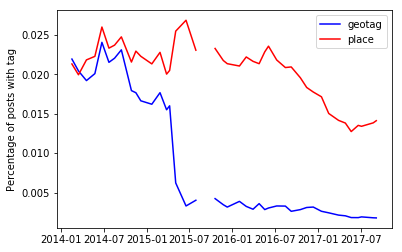

In [29]:
plt.plot(stats_df.loc[:, 'date'], stats_df.loc[:, 'geotagged_pct'], 'b', label='geotag')
plt.plot(stats_df.loc[:, 'date'], stats_df.loc[:, 'place_pct'], 'r', label='place')
plt.legend(loc='upper right')
plt.ylabel('Percentage of posts with tag')
plt.show()

Weird! There was a pretty big drop in geotagging around 2015-04 and a slight dip in place-tagging around 2016-08.